In [1]:
# imports 

# make notebook span full width of window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] + "Dragonfly44_SFH/" # hack, but works

import numpy as np
from Dragonfly44_SFH.utils import plotting

In [2]:
result_params = {}

from Dragonfly44_SFH.fitting.output.fits.fits_DF44_summary import *
from Dragonfly44_SFH.utils import prospect_io

path_fits = path_base+ "fitting/output/fits/"

path_data = path_base+ "data/"
file_data = path_data+"DF44/obs_phot_specKCWI_sigma110.h5"

for key, result_file, label in [ 
                           ['aD02', fit_aD02_phot_specKCWI,'alphaD = 0.2'],
#                            ['aD03', fit_aD03_phot_specKCWI,'alphaD = 0.3'],
                           ['aD05', fit_aD05_phot_specKCWI,'alphaD = 0.5'],
                           ['aD1', fit_aD1_phot_specKCWI,'alphaD = 1'],
                           ['csfrcont', fit_csfrcont_phot_specKCWI, 'cSFR continuity']
                          ]:

    result, obs, model = prospect_io.read_results( path_fits+ result_file, file_data=file_data )

    result_params[key] = dict( result=result, obs=obs, model=model, label=label )

zobs = float(model.params['zred'])

In [3]:
showkeys = ['aD02','aD05','aD1','csfrcont']


In [4]:
# CHECK if each fit provided a spectrum with rough specphot calibration
# e.g. fit_aD05_phot_specKCWI includes a spectrum with normalization = 1e-8
# other fits used normalization = 1, relying entirely on spectro-photometric calibration polynomial
# for consistency, remove the normalization term!
# this is an annoying inconsistency of this project...
specnorm = 1e-8

for key in showkeys:
    if result_params[key]['obs']['spectrum'] is None: continue # skip if phot-only fit
        
    specnorm_in_fit = np.median( result_params[key]['obs']['spectrum'] )
    if specnorm_in_fit < 1e-3: # somewhat arbitrary threshold
        
        result_params[key]['obs']['spectrum'] /= specnorm 
        result_params[key]['obs']['unc'] /= specnorm 

        result_params[key]['result']['bestfit']['spectrum'] /= specnorm 
        result_params[key]['result']['bestfit']['speccal'] /= specnorm 
        
        if 'draws' in result_params[key]['result']: # post-processing step not always done
            result_params[key]['result']['draws']['bestfit']['spectrum'] /= specnorm 
            result_params[key]['result']['draws']['bestfit']['speccal'] /= specnorm 

In [5]:
# setup styling

markers = ['o','s','X','v']
colors = ['orange','m','lime','c']

for i,key in enumerate( result_params.keys() ):
    result_params[key]['obs_params'] = {'marker':'D', 'color':'k', 'ms':12}
    result_params[key]['posts_params'] = {'color':colors[i]}
    result_params[key]['bestfit_params'] = {'color':colors[i], 'marker':markers[i]}



## plot SED

  draws not in file


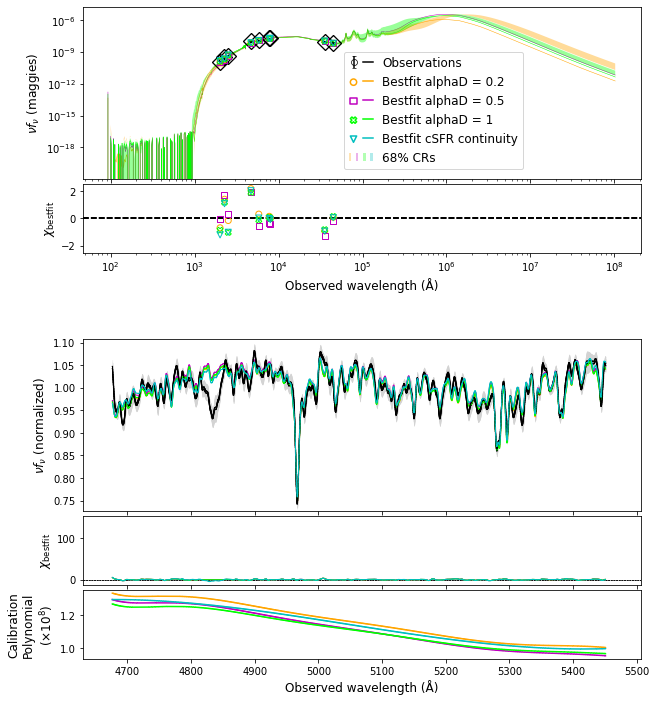

In [13]:
params_base = dict( return_fig=True, zobs=0, figsize=(10,12), show_chi2s=False )

fig = None
for key in showkeys:
    fig = plotting.plot_obs_and_fits( **result_params[key], fig=fig, **params_base )

if True: # add legend
    ax_legend = fig.get_axes()[0]

    handles, handles_CRs = [],[]
    labels = []
    for i,key in enumerate( showkeys ):
        pp = result_params[key]
        
        if i==0: # add handles for observations    
            ha = ax_legend.errorbar([-1],[-1], yerr=[1], 
                                     color=pp['obs_params']['color'], mec=pp['obs_params']['color'], 
                                     mfc='None', fmt=' ', capsize=2, ms=12, marker='o', mew=0.7)
            hb, = ax_legend.plot([],[], color=pp['obs_params']['color'])
            handles.append( (ha,hb) )
            labels.append('Observations')
        
        
            
        ha = ax_legend.scatter([],[], 
                               edgecolor=pp['bestfit_params']['color'], facecolor='None', 
                               marker=pp['bestfit_params']['marker'], zorder=2, s=160, lw=1.5, )
        hb, = ax_legend.plot([],[], color=pp['bestfit_params']['color'])
        handles.append( (ha,hb) )
        if 'label' in pp.keys(): l = pp['label']
        elif 'label' in pp['bestfit_params'].keys(): pp['bestfit_params']['label']
        else: l = i+1
        labels.append('Bestfit {}'.format( l ))
        
        h = ax_legend.fill_between([],[], 
                                   lw=0, color=pp['bestfit_params']['color'], alpha=0.3)
        handles_CRs.append( h )
        
    handles.append( tuple(handles_CRs) )
    labels.append( "68% CRs" )
     
    from matplotlib.legend_handler import HandlerTuple
    ax_legend.legend( handles, labels,
                      numpoints=1, loc=4, markerscale=0.5, bbox_to_anchor=[0.8,0.02],
                      handler_map={tuple: HandlerTuple(ndivide=None)},
                    )

plt.show()

## plot corner plot

In [6]:
par_settings = {
                'dust2':{'label':r"$\hat{\tau}_\mathrm{dust,~diffuse}$", 'bin_range':[0,0.5]},
                'logzsol':{'label':r"$\log(~Z_\ast/\mathrm{Z}_\odot~)$", 'bin_range':[-1.5,-0.9]},
                'logmass':{'label':r"*$\log(~M_{\ast,~\mathrm{total}}/\mathrm{M}_\odot~)$", 'bin_range':[8.2,8.7]},
                'logmass_stellar':{'label':r"*$\log(~M_{\ast}/\mathrm{M}_\odot~)$", 'bin_range':[8,8.5]},
                "mwa":{'label':r"*$t_\mathrm{mass}$ (Gyr)", 'bin_range':[8,13.5]},
                }

showpars = ['dust2','logzsol','logmass',
#             'logmass_stellar', # missing from some outputs (requires post-processing)
            "mwa"]


In [7]:
from Dragonfly44_SFH.utils.transforms import chain_to_param
from Dragonfly44_SFH.utils.misc_utils import weighted_quantile

for par in showpars:
    for key in showkeys:
        result = result_params[key]['result']
        x = chain_to_param( param=par, **result )
        w = result['weights']
        qnts = weighted_quantile( np.squeeze(x), quantiles=[0.16,0.5,0.84], sample_weight=w )
        print( '{:12}\t{} = {}'.format( key, par, qnts ) )
    print()

aD02        	dust2 = [0.17295155 0.19815529 0.23408031]
aD05        	dust2 = [0.16643892 0.19930945 0.19938377]
aD1         	dust2 = [0.19192584 0.238549   0.26950429]
csfrcont    	dust2 = [0.21421267 0.24168457 0.28907853]

aD02        	logzsol = [-1.2894049  -1.27080969 -1.24318738]
aD05        	logzsol = [-1.20649507 -1.20207902 -1.20201854]
aD1         	logzsol = [-1.18801713 -1.17814934 -1.16933044]
csfrcont    	logzsol = [-1.211323   -1.2112375  -1.19687842]

aD02        	logmass = [8.55441397 8.5850144  8.61725904]
aD05        	logmass = [8.4564267  8.51582115 8.51590533]
aD1         	logmass = [8.42041019 8.48411776 8.5009852 ]
csfrcont    	logmass = [8.56674931 8.57634677 8.58304418]

aD02        	mwa = [13.01781843 13.06068619 13.08363152]
aD05        	mwa = [11.79717759 11.85353958 11.88117784]
aD1         	mwa = [ 9.71920152 10.19549119 10.53930826]
csfrcont    	mwa = [13.03121026 13.06497693 13.07184828]



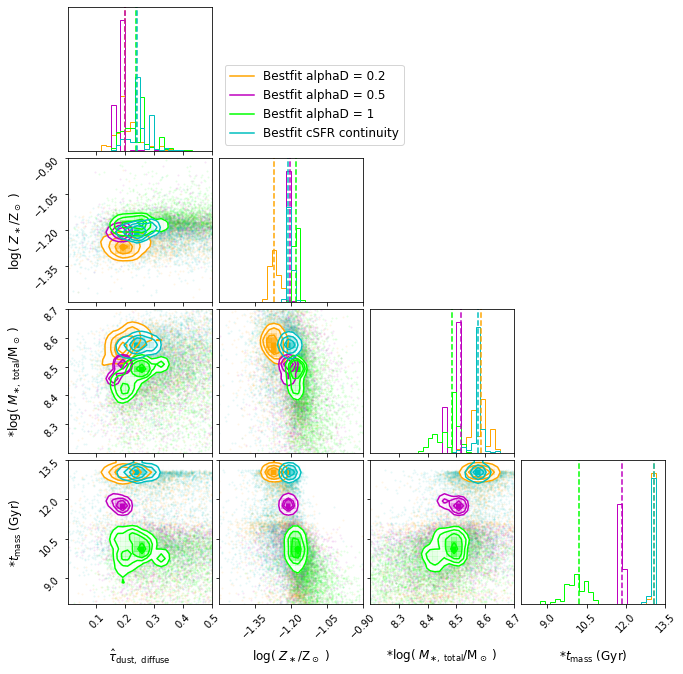

In [21]:
labels = [ par_settings[p]['label'] for p in showpars ]
bin_ranges = [ par_settings[p]['bin_range'] for p in showpars ]

xparams = dict( labels=labels, smooth=1, range=bin_ranges )
params_base = dict( showpars=showpars, smooth=1, show_titles=1, labels=labels, return_fig=1, xparams=xparams )

fig = None
for key in showkeys:
    fig = plotting.plot_corner( result=result_params[key]['result'], color=result_params[key]['posts_params']['color'], 
                                fig=fig, **params_base )
    
if True: # add legend
    ax_legend = fig.get_axes()[1]

    handles, labels = [],[]
    for i,key in enumerate( showkeys ):
        pp = result_params[key]
        h, = ax_legend.plot([],[], color=pp['bestfit_params']['color'])
        handles.append( h )
        if 'label' in pp.keys(): l = pp['label']
        elif 'label' in pp['bestfit_params'].keys(): pp['bestfit_params']['label']
        else: l = i+1
        labels.append('Bestfit {}'.format( l ))
     
    ax_legend.legend( handles, labels, loc=3 )    


## plot reconstructed SFH

In [6]:
# sample from prior

size = int(1e2) # better to have more draws, but takes longer

for key in showkeys:

    result_params[key]['prior_draws'] = prospect_io.get_sfh_priors( result_params[key]['model'], size )


In [7]:
# setup styling

hatches = ['//','\\','////','||||']

for i,key in enumerate( result_params.keys() ):
    result_params[key]['obs_params'] = {'marker':'D', 'color':'k', 'ms':12}
    result_params[key]['posts_params'] = {'color':colors[i]}
    result_params[key]['bestfit_params'] = {'lw':1, 'edgecolor':colors[i], 'facecolor':'None', 
                                            'marker':markers[i], 's':160 }
    result_params[key]['priors_params'] = {'facecolor':'None', 'edgecolor':colors[i], 'hatch':hatches[i], 'lw':0 }



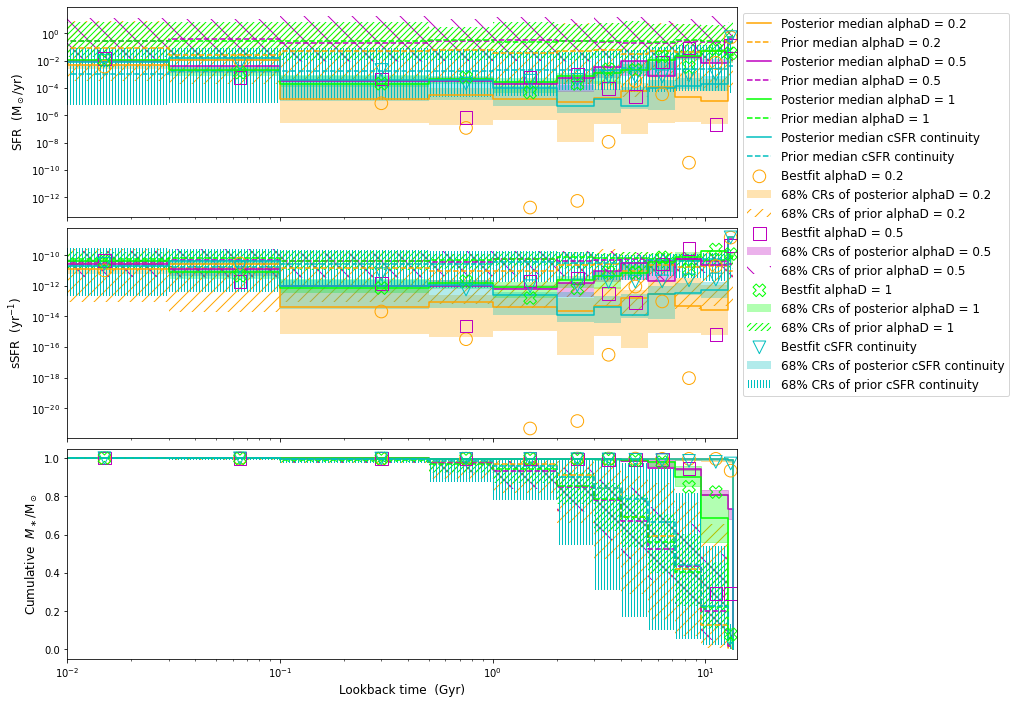

In [13]:
fig, axes = plt.subplots(3,1, figsize=(12,12), sharex=True)
fig.subplots_adjust( wspace=0.05, hspace=0.05 )        
ax_sfr,ax_ssfr,ax_cmf = axes.flatten()

for key in showkeys:
    pp = result_params[key]

    plotting.plot_sfh( ax_sfr, norm_by_mass=False, **pp )
    plotting.plot_sfh( ax_ssfr, norm_by_mass=True, **pp )
    plotting.plot_cmf( ax_cmf, xscale='linear', style='step', **pp )

[ ax.set_xlabel(None) for ax in axes[:-1]]
ax_sfr.legend( loc=2, bbox_to_anchor=[1,1])
ax_sfr.set_xscale('log')
ax_sfr.set_xlim(0.01, 14)
plt.show()